In [1]:
import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp, resize
%matplotlib notebook
                     # NOTE: all "magic" options for backend plotting are: inline, notebook, and "external" (default) 
                     # see  http://ipython.readthedocs.io/en/stable/interactive/plotting.html for details

### LineBuilder class for entering correspoinding points in each image
###### Note: left mouse clicks add polyline intervals, the right mouse click terminates the polyline, 'DEL' key removes the last click point

In [2]:
class LineBuilder:

    def __init__(self, axes, line):
        self.line = line
        self.ax = axes
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.dashed_line = plt.Line2D((0,0),(0,0), color = line.get_c(), ls=':', lw=line.get_linewidth())
        self.terminated = False
        
        self.connect()
        
    def connect(self):
        # 'connect to all the events we need'
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_click)
        self.cidmotion = self.ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.cidkey = self.ax.figure.canvas.mpl_connect('key_press_event', self.on_key_down)

        
    def on_click(self, event):
        if ((self.terminated==True) or (event.inaxes!=self.line.axes)): return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        #self.ax.add_patch(plt.Circle((event.xdata,event.ydata), radius=5, fc='y'))
        self.line.figure.canvas.draw()
        if (event.button==3): self.terminated = True   #right mouse click terminates the polyline 
            
    def on_motion(self, event):
        if ((self.terminated==True) or (event.inaxes!=self.line.axes) or (len(self.xs)==0)): return
        self.dashed_line.set_xdata([self.xs[-1],event.xdata])
        self.dashed_line.set_ydata([self.ys[-1],event.ydata])
        self.ax.add_line(self.dashed_line)
        
    def on_key_down(self, e): # do the following when certain "key" is pressed
        if (e.inaxes!=self.ax.axes): return
        if e.key == 'delete' :  # pressing 'DEL' key deletes the last click
            if self.xs : self.xs.pop()
            if self.ys : self.ys.pop()
            self.line.set_data(self.xs, self.ys)
            self.dashed_line.set_xdata([])
            self.dashed_line.set_ydata([])
            self.line.figure.canvas.draw()
            self.terminated = False
    
    def disconnect(self):
        # 'disconnect all the stored connection ids'
        self.ax.figure.canvas.mpl_disconnect(self.cidmotion)   
        self.ax.figure.canvas.mpl_disconnect(self.cidpress)
        self.ax.figure.canvas.mpl_disconnect(self.cidkey)

### CrossDissolver class
###### Note: click on the left side to move back to image A, clicks on the right side to move forward to image B

In [3]:
# ASSUMPTION: images A and B should have the same size and the same data type ('uint8' {0,1,2,...,255} or 'float' [0,1])
class CrossDissolver:

    def __init__(self, axes, imA, imB, dtype = 'uint8'):
        self.ax = axes
        scaler = 1.0/255.0
        if (dtype == 'float') : scaler = 1.0
        self.A = scaler * np.array(imA)    # generating array A with (RGB) float values in the range [0,1]
        self.B = scaler * np.array(imB)    # generating array B with (RGB) float values in the range [0,1]
        self.t = 0.5
        self.width = imA.shape[1]
        self.text_pos = (self.width+20, 20)                 
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_click)
        self.showMix()       
                            
    def on_click(self, event):
        if (event.inaxes!=self.ax.axes): return
        if (event.xdata>(self.width/2)):  self.t = min(1.0,self.t+0.1)
        if (event.xdata<(self.width/2)):  self.t = max(0.0,self.t-0.1)           
        self.showMix()
         
    def showMix(self):
        self.ax.imshow((1.0-self.t)*self.A + self.t*self.B)
        self.ax.text(self.text_pos[0], self.text_pos[1], 't = {:4.2f}'.format(self.t), color='y', backgroundcolor='gray') 

<IPython.core.display.Javascript object>


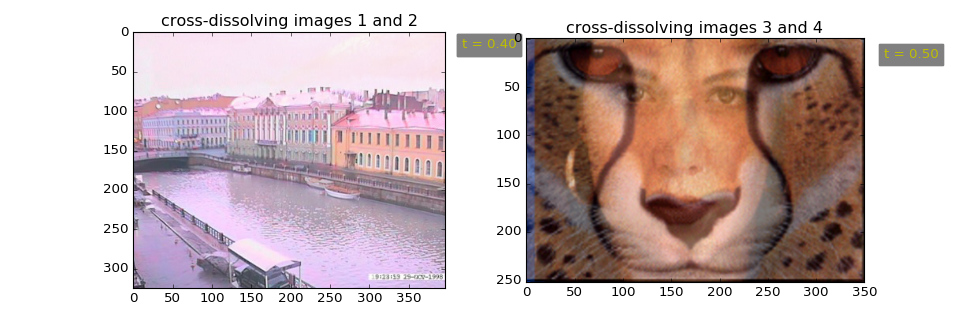

In [5]:
im1 =image.imread("images/Fontanka1.jpg")
im2 =image.imread("images/Fontanka2.jpg")

im3 =image.imread("images/woman.png")  # NOTE: images "woman.png" and "cheetah.png" have RGV values as floats in [0,1]
im4 =image.imread("images/cheetah.png")

fig = plt.figure(1,figsize = (12, 4))
ax12 = plt.subplot(121)
css12 = CrossDissolver(ax12,im1,im2)  # instantiates CrossDissolver object
plt.title("cross-dissolving images 1 and 2")

ax34 = plt.subplot(122)
css34 = CrossDissolver(ax34,im3,resize(im4,im3.shape),'float')  # we use resized image im4 to match the size of im3
plt.title("cross-dissolving images 3 and 4")

# Morphing

<IPython.core.display.Javascript object>


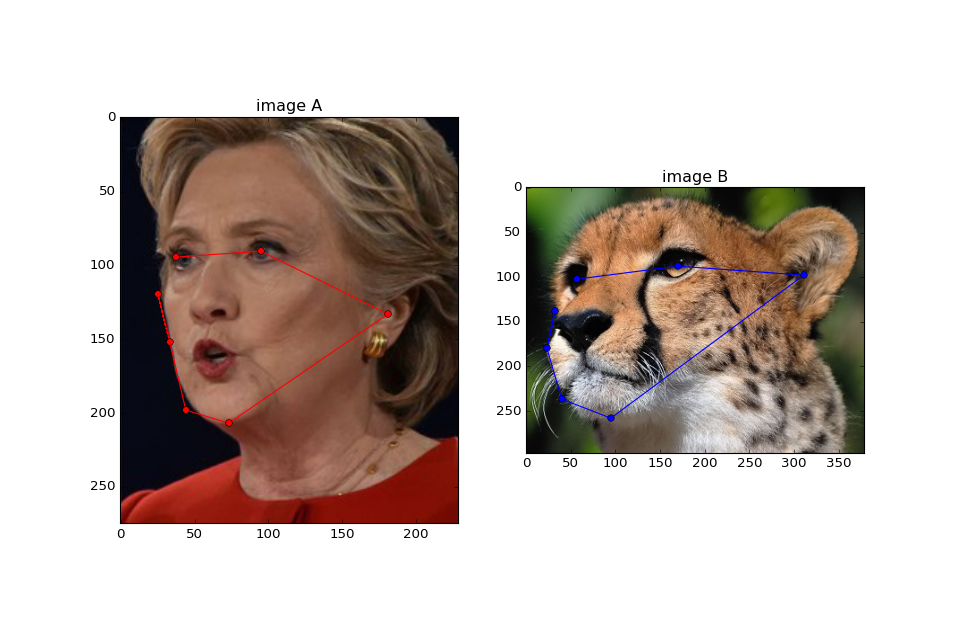

In [6]:
imA =image.imread("images/hilary3.jpg")
imB =image.imread("images/cheetah1.jpg")

fig = plt.figure(2,figsize = (12, 8))

axA = plt.subplot(121)
polylineA = LineBuilder(axA, plt.plot([], [], 'ro-')[0] )  # instantiates LineBuilder object
axA.imshow(imA)
plt.title("image A")

axB = plt.subplot(122)
polylineB = LineBuilder(axB, plt.plot([], [], 'bo-')[0] )  # instantiates LineBuilder object
axB.imshow(imB)
plt.title("image B")

plt.show()

# (Left) click on two images below to consecutively enter corresponding points (right clicks enter the last points)
# Press "DELETE" key to delete the last click point.

### Delaunay triangulation (2D mesh) over the points in each image 

<IPython.core.display.Javascript object>


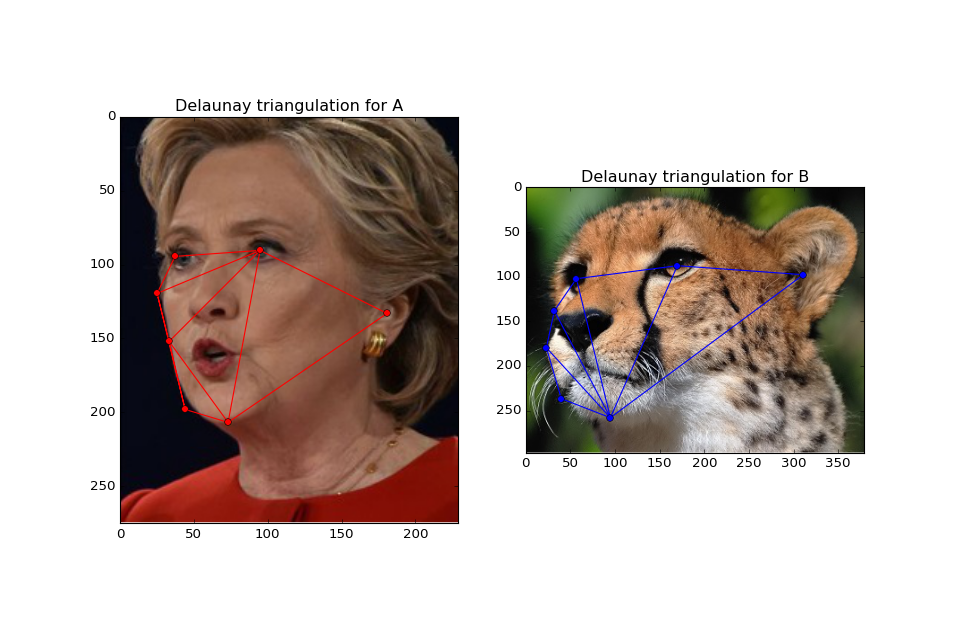

In [7]:
ptsA = polylineA.line.get_xydata()
ptsB = polylineB.line.get_xydata()
rowsA, colsA = imA.shape[0], imA.shape[1]
rowsB, colsB = imB.shape[0], imB.shape[1]

import matplotlib.tri as tri

triA = tri.Triangulation(ptsA[:,0],ptsA[:,1])
triB = tri.Triangulation(ptsB[:,0],ptsB[:,1])

plt.figure(3,figsize = (12, 8))
plt.subplot(121)
plt.axis((0, colsA, rowsA, 0))
plt.imshow(imA)
plt.triplot(triA, 'ro-')
plt.title('Delaunay triangulation for A')

plt.subplot(122)
plt.axis((0, colsB, rowsB, 0))
plt.imshow(imB)
plt.triplot(triB, 'bo-')
plt.title('Delaunay triangulation for B')

### Piece-wise Affine transformation between two meshes

In [8]:
pwAffAtoB = PiecewiseAffineTransform()
pwAffAtoB.estimate(ptsA, ptsB)  # estimates piece-wise affine transformation from A to B
                                # Each (Delaunay) triangle ABC over ptsA (triangulation is scomputed inside) 
                                # is mapped onto a triangle A'B'C' over ptsB implied by correspondences between ptsA and ptsB
                                # A distinct affine transformation is computed for each triangle 

True

### Warping images using piece-wise affine transformation computed above
###### NOTE 1: function "warp" uses "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities
###### NOTE 2: function "warp" generates images with RGB values as floats in range [0,1]    (float is a result of interpolation)

<IPython.core.display.Javascript object>


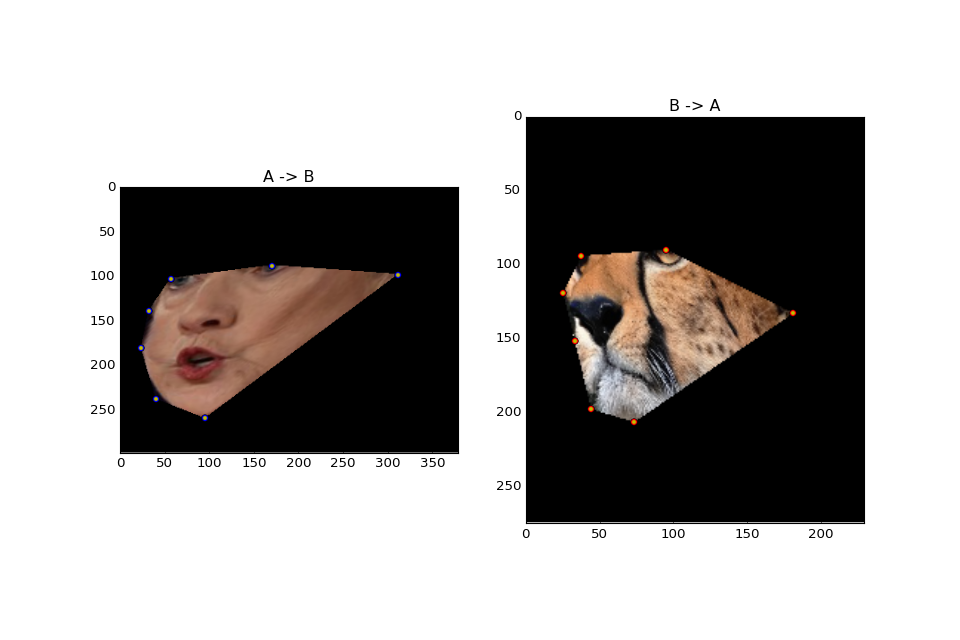

In [11]:
AtoB = warp(imA, pwAffAtoB.inverse, output_shape=(rowsB, colsB))
BtoA = warp(imB, pwAffAtoB, output_shape=(rowsA, colsA)) # pwAffAtoB is the inverse for B->A transform, i.e. pwAffAtoB.inverse

fig = plt.figure(4,figsize = (12, 8))

axA = plt.subplot(121)
axA.imshow(AtoB)
plt.title("A -> B")
axA.plot(ptsB[:, 0], ptsB[:, 1], 'ob')  # original click points in B are shown (blue circles) to compare accuracy of projection
axA.plot(pwAffAtoB(ptsA)[:, 0], pwAffAtoB(ptsA)[:, 1], '.y')  
axA.axis((0, colsB, rowsB, 0))

axB = plt.subplot(122)
axB.imshow(BtoA)
plt.title("B -> A")
axB.plot(ptsA[:, 0], ptsA[:, 1], 'or') # original click points in A are shown (red circles) to compare accuracy of projection
axB.plot(pwAffAtoB.inverse(ptsB)[:, 0], pwAffAtoB.inverse(ptsB)[:, 1], '.y')
axB.axis((0, colsA, rowsA, 0))

plt.show()

###  Interpolated (intermediate) warps for steps $t\in [0,1]$

In [12]:
# This function computes a warp of image A onto image B based on corresponding points given inside two images (pA and pB)
# Optional argument is the step size T in [0,1] with default value T=1.0 (full step)
# It is also possible to specify the size of the output image frame (in any case, "warp" fills out only mapped triangles)
# The function returns a transformed image and a set of stransformed points (at step t) 
def pwAff_T(pA, pB, A, B, T=1.0, shape = None):
    
    # YOUR CODE SHOULD BE WRITTEN HERE (also change the return values)
    # USE CAN USE FUNCTIONS PiecewiseAffineTransform() and warp()  
    # see documentation in http://scikit-image.org/docs/dev/api/skimage.transform.html

    return resize(A,shape), pA  # THIS RETURNED IMAGE IS WRONG, IT IS ONLY SCALED TO HAVE THE RIGHT shape

# NOTE!!! return image has RGB values as floats in interval [0,1] (property of functions "warp" or "resize")

# ALTERNATIVELY, you can change this function to use precomputed transform pwAffAtoB instead of points pA and pB
# as long as you figure out how to "interpolate" the corresponding image warp for 0<T<1

##### visualizing intermediate B -> A warps

<IPython.core.display.Javascript object>


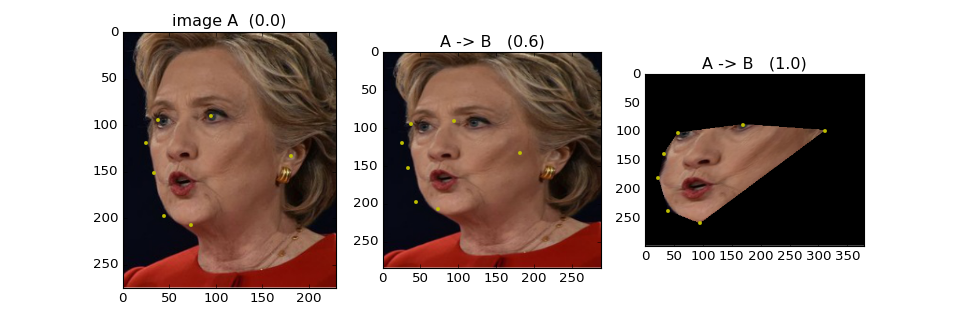

In [13]:
t = 0.6
rowsT, colsT = round(rowsB + t*(rowsA-rowsB)), round(colsB + t*(colsA-colsB))
AtoB_t, pts_t = pwAff_T(ptsA,ptsB,imA,imB, t, shape=(rowsT, colsT)) 

fig = plt.figure(5,figsize = (12, 4))
plt.subplot(131)
plt.axis((0, colsA, rowsA, 0))
plt.imshow(imA)
plt.title("image A  (0.0)")
plt.plot(ptsA[:, 0], ptsA[:, 1], '.y')

plt.subplot(132)
plt.axis((0, colsT, rowsT, 0))
plt.imshow(AtoB_t)
plt.title("A -> B   ({:3.1f})".format(t))
plt.plot(pts_t[:, 0], pts_t[:, 1], '.y')


plt.subplot(133)
plt.axis((0, colsB, rowsB, 0))
plt.imshow(AtoB)
plt.title("A -> B   (1.0)")
plt.plot(pwAffAtoB(ptsA)[:, 0], pwAffAtoB(ptsA)[:, 1], '.y')

plt.show()

# NOTE, the provided implementation for pwAff_T does not give the right intermediate warp results (middle image)

#### Cross-dissolving registered images A and B after warping them to the same intermediate frame $t\in [0,1]$

<IPython.core.display.Javascript object>


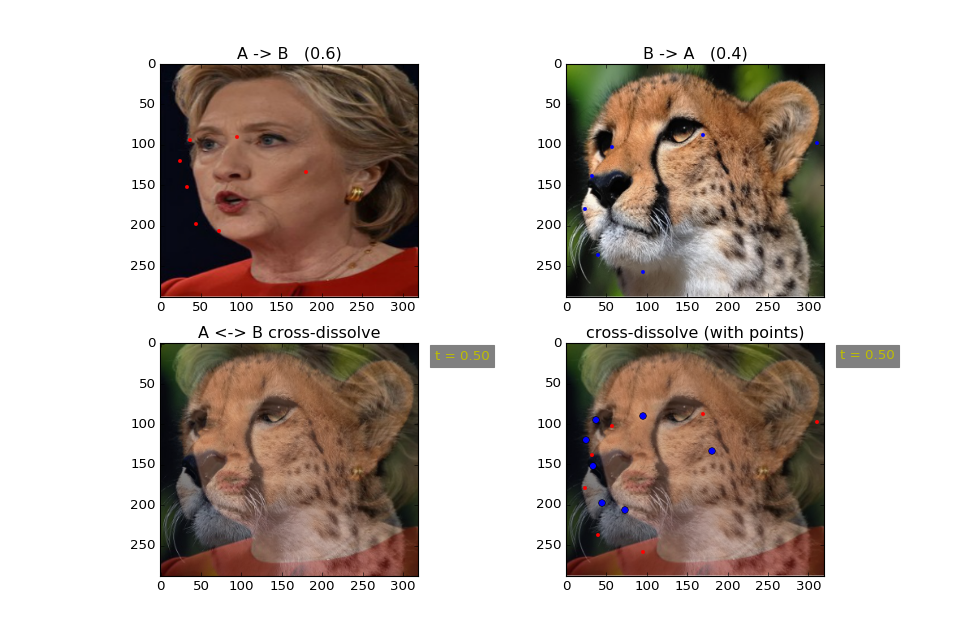

In [15]:
t = 0.6

# estimating common size for the intermediate frame
rowsT, colsT = round(rowsA + t*(rowsB-rowsA)), round(colsA + t*(colsB-colsA))

AtoB_t, pA_t = pwAff_T(ptsA,ptsB,imA,imB,t, shape = (rowsT,colsT))   
BtoA_t, pB_t = pwAff_T(ptsB,ptsA,imB,imA,1.0-t, shape = (rowsT,colsT))

fig = plt.figure(6,figsize = (12, 8))
plt.subplot(221)
plt.axis((0, colsT, rowsT, 0))
plt.imshow(AtoB_t)
plt.title("A -> B   ({:3.1f})".format(t))
plt.plot(pA_t[:, 0], pA_t[:, 1], '.r')

plt.subplot(222)
plt.axis((0, colsT, rowsT, 0))
plt.imshow(BtoA_t)
plt.title("B -> A   ({:3.1f})".format(1.0-t))
plt.plot(pB_t[:, 0], pB_t[:, 1], '.b')

ax3 = plt.subplot(223)
cf3 = CrossDissolver(ax3,AtoB_t,BtoA_t,'float')  # NOTE: pwAff_T generated float images
plt.title("A <-> B cross-dissolve")

ax4 = plt.subplot(224)
plt.axis((0, colsT, rowsT, 0))
cf4 = CrossDissolver(ax4,AtoB_t,BtoA_t,'float')  # NOTE: pwAff_T generated float images
plt.plot(pA_t[:, 0], pA_t[:, 1], 'ob')   # both points pA_t and pB_t are shown 
plt.plot(pB_t[:, 0], pB_t[:, 1], '.r')   # to validate registration at frame t
plt.title("cross-dissolve (with points)")

plt.show()

# NOTE: for correctly implemented pwAff_T, red and blue dots at the top images should match with the selected featrues,
# red and blue points at the botton right image should coinside and the images should be registered when cross-dissolved

### Morpher class (morphing two images)
###### Note: click on the left side to move back to image A, clicks on the right side to move forward to image B

In [16]:
# The Morpher generates intermediate steps T in [0,1] morphing image A onto B 
# NOTE: images imA and imB do NOT have to be of the same size
class Morpher:

    def __init__(self, axes, ptsA, ptsB, imA, imB, shape = None, showPts = False):
        self.ax = axes
        self.A = imA
        self.B = imB
        self.ptsA = ptsA
        self.ptsB = ptsB
        self.T = 0.5
        self.showPts = showPts
        self.morph_shape = shape
        if (shape==None): self.morph_shape = (max(imA.shape[0],imB.shape[0]), max(imA.shape[1],imB.shape[1]))
        self.width = self.morph_shape[1]
        self.text_pos = (self.width+20, 20) 
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_click)

        self.ax.axis((0, self.morph_shape[1], self.morph_shape[0], 0))
        self.showMorph()
                            
    def on_click(self, event):
        if (event.inaxes!=self.ax.axes): return
        if (event.xdata>(self.width/2)):  self.T = min(1.0,self.T+0.1)
        if (event.xdata<(self.width/2)):  self.T = max(0.0,self.T-0.1)            
        self.showMorph()
             
    def showMorph(self):
        
        # WRITE YOUR CODE TO SHOW MORPH BETWEEN IMAGES A TO B (REPLACING CROSS-DISSOLVE CODE BELOW) FOR GIVEN self.T
        # NOTE: YOU SHOULD SHOW POINTS (IN BLUE AND RED) ptsA and ptsB MAPPED ONTO SELECTED FRAME 0<T<1 (IN CASE showPts ==True)
        # CORRECTLY MAPPED CORRESPONDING POINTS SHOULD COINSIDE WITH EACH OTHER AND WITH SELECTED IMAGE FEATURES 
        if (self.showPts) : self.ax.plot(ptsA[:, 0], ptsA[:, 1], 'ob')     
        if (self.showPts) : self.ax.plot(ptsB[:, 0], ptsB[:, 1], '.r')     
            
        self.ax.imshow((1.0-self.T)*np.array(self.A)/255 + self.T*np.array(resize(self.B,self.A.shape)))
        self.ax.text(self.text_pos[0], self.text_pos[1], 'T = {:4.2f}'.format(self.T), color='y',backgroundcolor='gray')  
        
        # NOTE: "resize" just like "warp" rescale RGB values to floats in [0,1] 
        # Thus, in my imshow above I have to resaling self.A RGB uint8 values to floats in [0,1] by deviding by 255
        # Chances are, you will not need this in your code since both mixes images would be generated by some "warp"

<IPython.core.display.Javascript object>


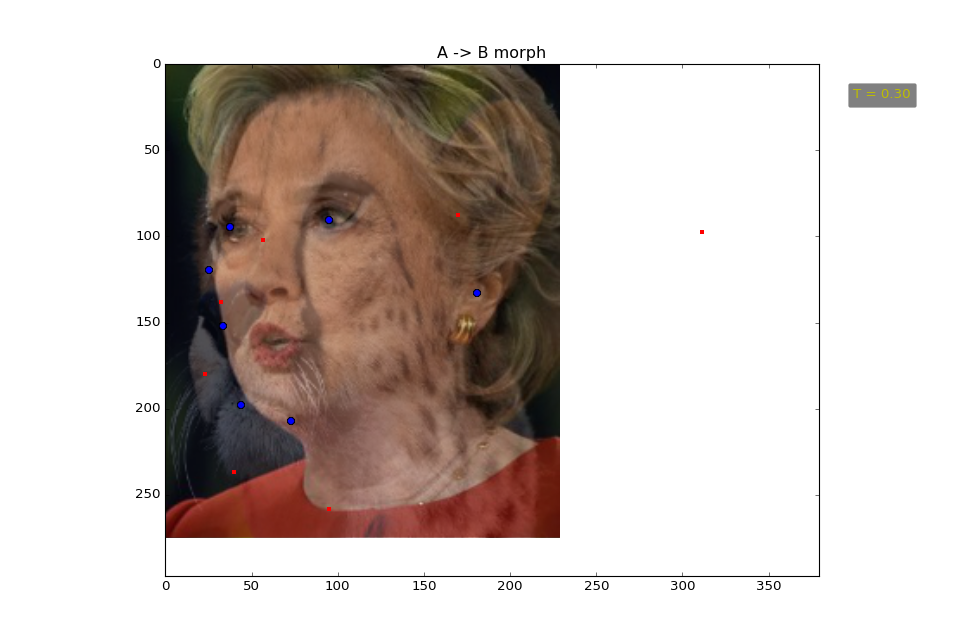

In [17]:
plt.figure(7,figsize = (12, 8))
axM = plt.subplot(111)
myMorph = Morpher(axM,ptsA,ptsB,imA,imB, showPts = True)  # instantiates Morpher object
plt.title("A -> B morph")

# Click anywhere on the left side to move closer to imA and click on the right side to move closer to imB 
# Morpher object increments or deincrements T after such clicks.